In [2]:
import glob
import venn
from scipy.cluster.hierarchy import dendrogram, linkage
from neupy import algorithms
from scipy.stats.stats import pearsonr   
from scipy.interpolate import interp1d
import itertools as it
import statsmodels.stats.multitest as multi
import Colors
from matplotlib.patches import Rectangle, Circle
from colour import Color

In [3]:
np.random.seed(173612)

In [4]:
def zscore(df):
    df = df.loc[df.index[df.sum(axis=1)>0]]
    zdf = df.T
    zdf = (zdf-zdf.mean())/zdf.std()
    zdf = zdf.T
    return zdf

def scalezscore(zdf):
    df  = ((zdf.T>=0)*zdf.T/zdf.max(axis=1) + (zdf.T<0)*zdf.T/abs(zdf.min(axis=1))).T
    return df

# read Lfng tomo data

In [5]:
zdf_L = read_csv('../mGav_Lfng_zscores.tsv', sep = '\t', index_col=0)

In [6]:
zdf_L.index = ['_'.join(idx.rsplit('_')[:2]) for idx in zdf_L.index]

In [7]:
gene_corr_L = read_csv('../results/lfngMouseGastruloids/geneCorrelations_5dAA.tsv', sep = '\t', index_col=0)

In [8]:
gene_corr_L.index = ['_'.join(idx.rsplit('_')[:2]) for idx in gene_corr_L.index]

In [9]:
pvcols = [c for c in gene_corr_L.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 3
genelist_L = gene_corr_L.index[gene_corr_L.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [10]:
len(genelist_L), len(gene_corr_L)

(1456, 25828)

# read E14IB10 data

In [11]:
file = '/Users/anna/Dropbox/gastruloids/data/E14-mGstl-tomo/mGav_E14_zscores.tsv'
zdf_E = read_csv(file, sep = '\t', index_col=0)

In [12]:
zdf_E.index = ['_'.join(idx.rsplit('_')[:2]) for idx in zdf_E.index]

In [13]:
file = '/Users/anna/Dropbox/gastruloids/data/E14-mGstl-tomo/results_postRevJan19/geneCorrelations_5dAA.tsv'
gene_corr_E = read_csv(file, sep = '\t', index_col=0)

In [14]:
gene_corr_E.index = ['_'.join(idx.rsplit('_')[:2]) for idx in gene_corr_E.index]

In [15]:
pvcols = [c for c in gene_corr_E.columns if 'pv_('==c[:4]]
pvth = 0.1; nth = 5
genelist_E = gene_corr_E.index[gene_corr_E.apply(lambda x: sum(x[pvcols]<pvth), axis = 1) >= nth]

In [16]:
len(genelist_E), len(gene_corr_E)

(1199, 17091)

# gene set comparisons

/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:17: UserWarning: `get_labels()` is retained for backwards compatibility; use `generate_petal_labels()` or the higher level `venn()` instead
  "use `generate_petal_labels()` or the higher level `venn()` instead"
/Users/anna/anaconda/envs/py36/lib/python3.6/site-packages/venn/_backwards_compatibility.py:32: UserWarning: `venn2()` is retained for backwards compatibility; use `venn()` instead
  "use `venn()` instead"


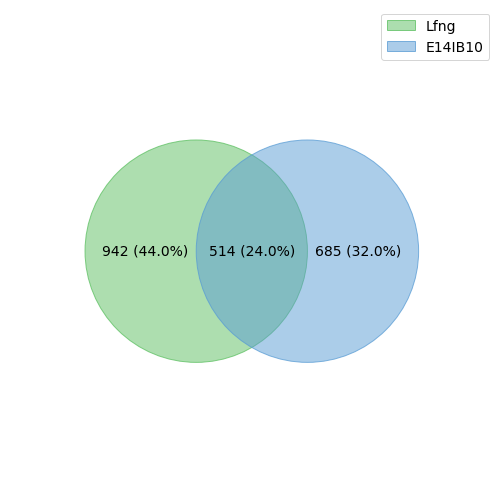

In [17]:
labels = venn.get_labels([set(genelist_L),
                          set(genelist_E)], 
                         fill=['number','percent'])

for k in labels:
    if labels[k][0:1]=='0': 
        labels[k] = ''
        
fig, ax = venn.venn2(labels, names=['Lfng', 'E14IB10'])

plt.savefig('../results/comparison_Lfng_E14IB10_gastruloids/venn_genesPval01.pdf', bbox_inches = 'tight')
plt.show()

# clustering

In [18]:
def SOMclustering(df, gridheight = 10, gridwidth = 10, seed = 54321):
    np.random.seed = seed
    GRID_HEIGHT = gridheight
    GRID_WIDTH = gridwidth
    somfun = algorithms.SOFM(
            n_inputs=len(df.columns),
            features_grid=(GRID_HEIGHT, GRID_WIDTH),
            learning_radius=4,
            reduce_radius_after=50,
            step=0.5,
            std=1,
            shuffle_data=True,
            verbose=False)
    somfun.train(np.array(df), epochs = 300)
    clustersr = somfun.predict(np.array(df)).argmax(axis=1)
    cl_genelist_df = pd.Series(clustersr, index = df.index)
    return cl_genelist_df

def hierarchicalClustering(df, cth = 100, plot = False, method = 'ward', metric = 'euclidean', nolabels = 'True'):
    Z = linkage(df, method=method, metric = metric)
    dg = dendrogram(Z, no_labels=nolabels, color_threshold=cth, no_plot = np.invert(plot))
    plt.show()
    return Z, dg

def getClusterByColor(dg, labels):
    kk = []
    ii = 0
    cluster = 0
    color = dg['color_list'][0]
    clusters = {cluster: []}
    for i in range(len(dg['icoord'])):
        v = dg['icoord'][i]
        for j in [0,2]:
            vj = int(round((v[j]-5.)/10))
            if (v[j]-5.)/10 == vj and vj not in kk:
                kk.append(vj)
                if dg['color_list'][i] == color:
                    clusters[cluster].append(labels[dg['leaves'][vj]])
                else:
                    color = dg['color_list'][i]
                    cluster += 1
                    clusters[cluster] = [labels[dg['leaves'][vj]]]
    return clusters

def comboCluster(df, genes, gridheight = 10, gridwidth = 10, cth = 100, plot = True, method = 'ward', metric = 'euclidean', seed = 12345, nolabels = 'True'):
    somcl = SOMclustering(df.loc[genes], gridheight = gridheight, gridwidth = gridwidth, seed = seed)
    mdf_som = pd.DataFrame({i: df.loc[somcl[somcl==i].index].mean() for i in set(somcl) })
    Z, dg = hierarchicalClustering(mdf_som.T, cth = cth, plot = plot, method = method, metric = metric, nolabels = nolabels)
    if plot:
        plt.show()
    ghcl = getClusterByColor(dg, list(mdf_som.columns))
    cl_df = pd.DataFrame(somcl, columns = ['som'])
    cl_df['hcl'] = [k for s in cl_df['som'] for k in ghcl.keys() if s in ghcl[k]]
    return cl_df

In [19]:
def mergeDfs(dfs):
    mdf = dfs[0]
    for i in range(1, len(dfs)):
        mdf = mdf.merge(dfs[i], how = 'outer', left_index = True, right_index = True)
    mdf = mdf.fillna(0)
    mdf = mdf.loc[mdf.sum(axis=1).sort_values(ascending=False).index]
    return mdf

In [20]:
zdf_E.columns = [str(c) + '-E14' for c in zdf_E.columns]
zdf_L.columns = [str(c) + '-Lfng' for c in zdf_L.columns]

In [21]:
mzdf = mergeDfs([zdf_E] + [zdf_L])

# Only L genes

In [22]:
len(genelist_L)

1456

In [23]:
genelist_excl_L = [g for g in genelist_L if g not in genelist_E]
len(genelist_excl_L)

942

In [24]:
genelist_ReprL_notDetE = [g for g in genelist_excl_L if g not in zdf_E.index or zdf_E.loc[g].sum()==0]
len(genelist_ReprL_notDetE), 5*np.sqrt(len(genelist_ReprL_notDetE))

(76, 43.58898943540674)

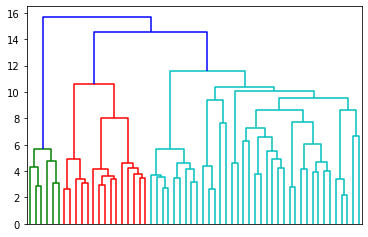

In [25]:
somhcl_LnotE_df = comboCluster(mzdf, genelist_ReprL_notDetE, cth=12, gridheight=8, gridwidth=10)

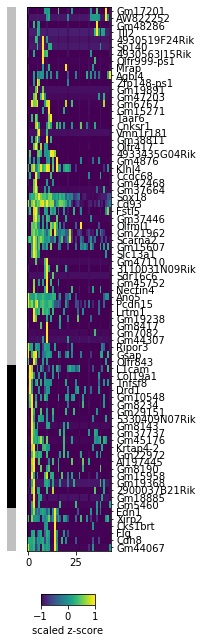

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (1.5,10))

hcl = somhcl_LnotE_df
gene_order = hcl.sort_values(by=['hcl','som']).index

df = zdf_L
im = ax.imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
ax.set_yticks([])
ax.tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax.set_yticks([i for i, g in enumerate(gene_order[::-1]) ])
ax.set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1]])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im, label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(df.columns)
x0 = -2.5*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax.add_patch(rect)
    y0 -= n

plt.savefig('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_reprLgenes_notE.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_reprLgenes_notE.tsv', sep = '\t')
plt.show()

In [27]:
genelist_ReprL_DetE = [g for g in genelist_excl_L if g not in genelist_ReprL_notDetE]
len(genelist_ReprL_DetE), 5*np.sqrt(len(genelist_ReprL_DetE))

(866, 147.13938969562162)

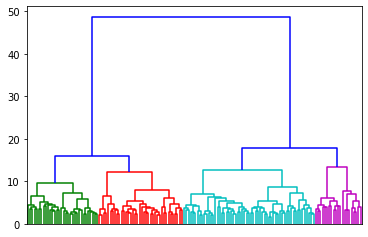

In [28]:
somhcl_L_df = comboCluster(mzdf, genelist_ReprL_DetE, cth=14, gridheight=15, gridwidth=10)

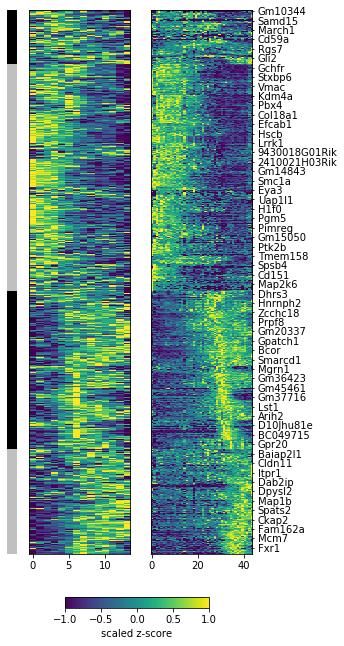

In [29]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (4,10))

hcl = somhcl_L_df
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate([zdf_E, zdf_L]):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i,15)==1])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if np.mod(i,15)==1])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(zdf_E.columns)
x0 = -2.5*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_reprLgenes_noreprE.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_reprLgenes_noreprE.tsv', sep = '\t')

plt.show()

# Only E genes

In [30]:
len(genelist_E)

1199

In [31]:
genelist_excl_E = [g for g in genelist_E if g not in genelist_L]
len(genelist_excl_E)

685

In [32]:
genelist_ReprE_notDetL = [g for g in genelist_excl_E if g not in zdf_L.index or zdf_L.loc[g].sum()==0]
len(genelist_ReprE_notDetL), 5*np.sqrt(len(genelist_ReprE_notDetL))

(0, 0.0)

In [33]:
genelist_ReprE_DetL = [g for g in genelist_excl_E if g not in genelist_ReprE_notDetL]
len(genelist_ReprE_DetL), 5*np.sqrt(len(genelist_ReprE_DetL))

(685, 130.86252328302402)

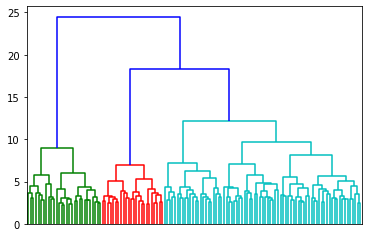

In [34]:
somhcl_E_df = comboCluster(mzdf, genelist_ReprE_DetL, cth=14, gridheight=13, gridwidth=10)

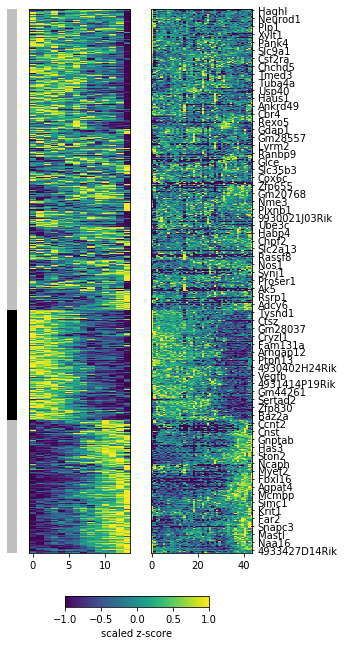

In [35]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (4,10))

hcl = somhcl_E_df
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate([zdf_E, zdf_L]):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if np.mod(i, 10)==1])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if np.mod(i, 10)==1])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(zdf_E.columns)
x0 = -2.5*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_reprEgenes_noreprL.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_reprEgenes_noreprL.tsv', sep = '\t')

plt.show()

# Genes reproducible in both

In [36]:
genelist_combined = list(set(list(genelist_E) + list(genelist_L)))

#', '.join(sorted([g.rsplit('_')[-1] for g in genelist_combined if g in genelist_E and g in genelist_L]))

In [37]:
len(genelist_combined), 942 + 514 + 685

(2141, 2141)

In [38]:
genelist_restricted = [g for g in genelist_combined if g in genelist_E and g in genelist_L]

In [39]:
len(genelist_restricted)

514

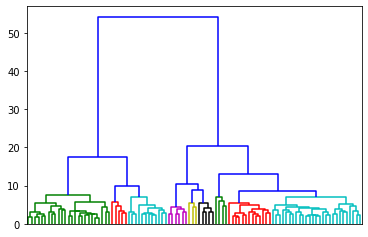

In [40]:
somhcl_all_df = comboCluster(mzdf, genelist_restricted, cth=8)

In [41]:
g_annotate=['Cdx2','Rspo3','Sox1','Sox2','Wnt3a','Fgf8','Uncx','Aldh1a2','Nkx1-2','Cyp26a1', 'Foxb1', 'Ets2',
            'Hes3','Pax6','Irx3','Irx5','Sox21','Dbx1','Dll1','Meox1','Tcf15','Pax3','Ptn','Klf3','Spon1', 'Rab3il1',
          'Mesp2','Ripply2','Dppa5a','Meox1','Tbx6','T', 'Hand1', 'Hand2', 'Gata6', 'Mef2c']
g_annotate = ['T', 'Nkx1-2', 'Cyp26a1', 'Sox2', 'Hes3', 'Sox1', 'Pax6', 'Fgf8',
        'Fgf17', 'Wnt3a', 'Tbx6', 'Hex7', 'Dll1', 'Ripply2', 'Tbx18', 'Uncx', 'Pax7', 'Pax3',
        'Gata6', 'Hand2']

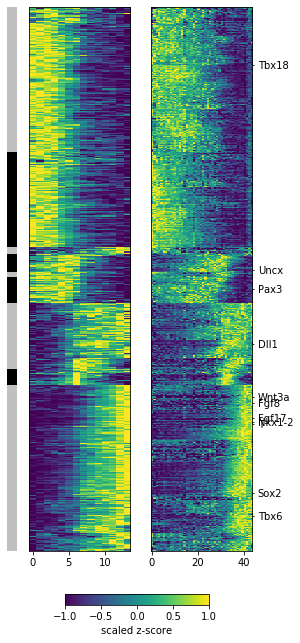

In [42]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (4,10))

hcl = somhcl_all_df
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate([zdf_E, zdf_L]):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(zdf_E.columns)
x0 = -2.5*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n

plt.savefig('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_reprELgenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_reprELgenes.tsv', sep = '\t')

plt.show()

In [43]:
len(genelist_combined), 5*np.sqrt(len(genelist_combined))

(2141, 231.3547060251855)

In [44]:
genelist_combined = [g for g in genelist_combined if g in zdf_E.index and g in zdf_L.index]

In [45]:
len(genelist_combined), 5*np.sqrt(len(genelist_combined))

(2065, 227.21135535003526)

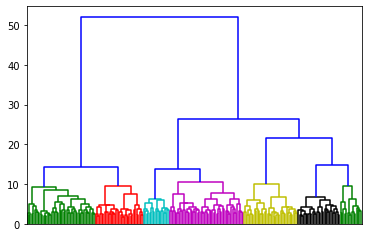

In [46]:
somhcl_all_df = comboCluster(mzdf, genelist_combined, cth=12, gridheight=23, gridwidth=10)

In [47]:
pvcols = [c for c in gene_corr_E.columns if 'pv_('==c[:4]]
gcE = gene_corr_E[pvcols].mean(axis=1)

In [48]:
pvcols = [c for c in gene_corr_L.columns if 'pv_('==c[:4]]
gcL = gene_corr_L[pvcols].mean(axis=1)

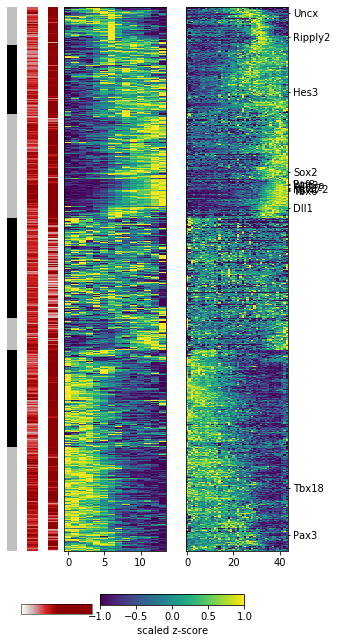

In [49]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize = (4,10))

hcl = somhcl_all_df
gene_order = hcl.sort_values(by=['hcl','som']).index

im = ['' for i in range(len(ax))]
for i, df in enumerate([zdf_E, zdf_L]):
    im[i] = ax[i].imshow(scalezscore(df.loc[gene_order][::-1]), aspect = 'auto')
    ax[i].set_yticks([])
ax[-1].tick_params('y', length = 2, labelleft=False, labelright=True, left = False, right=True)
ax[-1].set_yticks([i for i, g in enumerate(gene_order[::-1]) if g.rsplit('_')[1] in g_annotate])
ax[-1].set_yticklabels([g.rsplit('_')[1] for g in gene_order[::-1] if g.rsplit('_')[1] in g_annotate])

cbaxes = fig.add_axes([0.25, 0.05,0.5, 0.015])
fig.colorbar(im[-1], label = 'scaled z-score', orientation = 'horizontal', cax = cbaxes)

dx = 0.1*len(zdf_E.columns)
x0 = -6*dx
y0 = len(hcl)-0.5
for cl in set(hcl['hcl']):
    c = 'silver' if np.mod(cl,2)==0 else 'k'
    n = (hcl['hcl']==cl).sum()
    rect = Rectangle((x0,y0-n), dx, n, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= n
    
npoints = 100
xra = np.linspace(0,1,npoints)
gcolors = list(Color('darkred').range_to(Color('white'),npoints-1))
colors = {(xra[i],xra[i+1]): gcolors[i].hex_l for i in range(npoints-1)}
x0 = -4*dx
y0 = len(hcl)-0.5
n = 0
for i, g in enumerate(gene_order):
    c = colors[[i for i in colors if i[0]<=gcE.loc[g]<i[1]][0]]
    rect = Rectangle((x0,y0-n), dx, 1, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= 1
    
x0 = -2*dx
y0 = len(hcl)-0.5
n = 0
for i, g in enumerate(gene_order):
    c = colors[[i for i in colors if i[0]<=gcL.loc[g]<i[1]][0]]
    rect = Rectangle((x0,y0-n), dx, 1, lw = 2, edgecolor = None, facecolor = c, clip_on=False)
    ax[0].add_patch(rect)
    y0 -= 1

dxx = 0
for i, c in enumerate(list(colors.keys())[::-1]):
    rect = Rectangle((-6.5+dxx,len(gene_order)+200), dxx+0.05, 40, edgecolor = None, facecolor = colors[c], clip_on=False)
    ax[0].add_patch(rect)
    dxx += 0.05
rect = Rectangle((-6.5,len(gene_order)+200), 2*dxx-0.05, 40, edgecolor = 'k', fill = False, clip_on=False, lw = 0.5)
ax[0].add_patch(rect)
    
plt.savefig('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_allELgenes.pdf', bbox_inches = 'tight')
hcl.sort_values(by=['hcl','som']).to_csv('../results/comparison_Lfng_E14IB10_gastruloids/heatmap_allELgenes.tsv', sep = '\t')

plt.show()

In [50]:
pd.DataFrame(pd.Series([idx.rsplit('_')[1] for idx in somhcl_all_df.index])).to_csv('../results/comparison_Lfng_E14IB10_gastruloids/GOanalysis/population.tsv', sep = '\t', index = None, header = None)


In [51]:
for cl in set(somhcl_all_df['hcl']):
    pd.DataFrame(pd.Series([idx.rsplit('_')[1] for idx in somhcl_all_df[somhcl_all_df['hcl']==cl].index])).to_csv('../results/comparison_Lfng_E14IB10_gastruloids/GOanalysis/cl' + str(cl).zfill(2) + '.tsv', sep = '\t', index = None, header = None)
    